## Package importing and setting

In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from scipy.stats import kendalltau
from sklearn.feature_selection import f_classif
from joblib import dump
import re, os
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Data importing and train-validation-test splitting

#### Read in data

In [22]:
df_client = pd.read_csv("../data/raw/df_client.csv")

#### Train-validation-test splitting: 60% - 20% - 20%

In [23]:
# split into 0.6 - 0.2 - 0.2 : train - validation - test datasets
X_train, X_test, y_train, y_test = train_test_split(df_client.drop(columns=["risk_rating", "Self_exclude_flag"]), 
                                                    df_client[["risk_rating", "Self_exclude_flag"]],
                                                    test_size=0.2, random_state=0)
# note that 0.8 * 0.25 = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                      y_train,
                                                      test_size=0.25, random_state=0)
# save the three splited data, and only work on training data here, while saving the other two for later use
df_train = y_train.join(X_train)
df_valid = y_valid.join(X_valid)
df_test = y_test.join(X_test)

if not os.path.exists("../data/processed"):
    os.mkdir("../data/processed")
df_train.to_csv("../data/processed/df_train.csv")
df_valid.to_csv("../data/processed/df_valid.csv")
df_test.to_csv("../data/processed/df_test.csv")

## Missing data and outliers handling

#### Removing rows with *all* variable values missing

In [24]:
# first count number of rows with all variable missing
print(df_train.iloc[:,6:].isna().all(axis=1).sum())

# remove rows with all variable data missing since it's a small portion and 
# these rows are definitely useless
df_train = df_train.iloc[(~df_train.iloc[:,6:].isna().all(axis=1)).tolist(),:]

120


#### Removing outliers 
This is done before handling missing data because when using mean/regression imputation, **extreme** outliers could cause bias for the mean. So, removing the extreme outliers beforehead could improve the imputation results.

In [25]:
# Since the data contains some extreme outliers (such as 260 million where the mean is about 600k),
# extreme outliers (more than 2 sd's away from the mean) are removed before imputation, so that the
# statistics of the data are not affected greatly by the outliers.
mean_variables = np.asarray(df_train.iloc[:,6:].mean())
sd_variables = np.asarray(df_train.iloc[:,6:].std())
df_train = df_train.iloc[(~(np.abs(df_train.iloc[:,6:] - mean_variables) > sd_variables * 2).any(axis=1)).to_list(),:]

# save the original data mean and standard deviation to apply the same capping filter on the validation
# and the test datasets.
if not os.path.exists("../references"):
    os.mkdir("../references")
with open("../references/mean_sd.npy", "wb") as f:
    np.save(f, np.concatenate((mean_variables.reshape(1,-1), sd_variables.reshape(1,-1))))

#### Missing data handling
Four different methods were used to handle missing data, and the four methods will be compared in terms of the prediction accuracy measure of a simple model fitted on each of the four datasets. 

In [26]:
# next, try different methods of missing data handling

# 1. drop columns with more than 20% missing data, and then drop any rows with missing data
df_train_1 = df_train.loc[:, df_train.isna().mean() < 0.2].dropna().copy()

# 2. drop columns with more than 40% missing data, and then drop any rows with missing data
df_train_2 = df_train.loc[:, df_train.isna().mean() < 0.4].dropna().copy()

# 3. impute the missing data with the mean

# impute with mean
df_train_3 = df_train.copy()
simple_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
simple_imp.fit(df_train_3.iloc[:,6:])
df_train_3.iloc[:,6:] = simple_imp.transform(df_train_3.iloc[:,6:])

# 4. impute the missing data using regression
# Similarly, to have the regression work well, the filtered original data was used to run the regression
df_train_4 = df_train.copy()
reg_imp = IterativeImputer(max_iter=20, random_state=0, verbose=2)
reg_imp.fit(df_train_4.iloc[:,6:])
df_train_4.iloc[:,6:] = reg_imp.transform(df_train_4.iloc[:,6:])

dump(simple_imp, "../references/simple_imputer.joblib")
dump(reg_imp, "../references/regression_imputer.joblib")

[IterativeImputer] Completing matrix with shape (13190, 118)
[IterativeImputer] Ending imputation round 1/20, elapsed time 13.70
[IterativeImputer] Change: 2439544054.2716827, scaled tolerance: 1050623.067 
[IterativeImputer] Ending imputation round 2/20, elapsed time 27.08
[IterativeImputer] Change: 852795103.6860434, scaled tolerance: 1050623.067 
[IterativeImputer] Ending imputation round 3/20, elapsed time 40.39
[IterativeImputer] Change: 590955136.554155, scaled tolerance: 1050623.067 
[IterativeImputer] Ending imputation round 4/20, elapsed time 53.71
[IterativeImputer] Change: 480131886.25400513, scaled tolerance: 1050623.067 
[IterativeImputer] Ending imputation round 5/20, elapsed time 67.06
[IterativeImputer] Change: 248842963.09415054, scaled tolerance: 1050623.067 
[IterativeImputer] Ending imputation round 6/20, elapsed time 80.59
[IterativeImputer] Change: 127588480.97872825, scaled tolerance: 1050623.067 
[IterativeImputer] Ending imputation round 7/20, elapsed time 94.1

['../references/regression_imputer.joblib']

## Feature selection based on *inter-feature* correlation

#### 1. Correlation between *years* (Y0, Y1, Y2, Y3) for each variable

In [27]:
# look at the correlation within each variable after handling missing data
def plot_within_var_corr(df):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, axs = plt.subplots(5, 6, figsize = (24,21))

    for i in range(30):
        cols = list(filter(lambda x: x.startswith(f'Variable_{i+1}_'), df.columns))
        axs[i//6][i%6].set_title(f"Variable_{i+1}")
        if len(cols) > 0:
            sns.heatmap(data=df[cols].corr(), ax=axs[i//6][i%6], cmap=cmap, annot=True, vmin=-1, vmax=1,
                        xticklabels=False, yticklabels=False, square=True, cbar=False)

    fig.colorbar(axs[1][0].get_children()[0], ax=axs.ravel().tolist(), aspect=100, 
                 location="top", orientation="horizontal", anchor=(0.5, 1.5))
    fig.suptitle("Correlation between years (Y0, Y1, Y2, Y3) of each variable", fontsize=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    plt.show()

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\1651739324.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


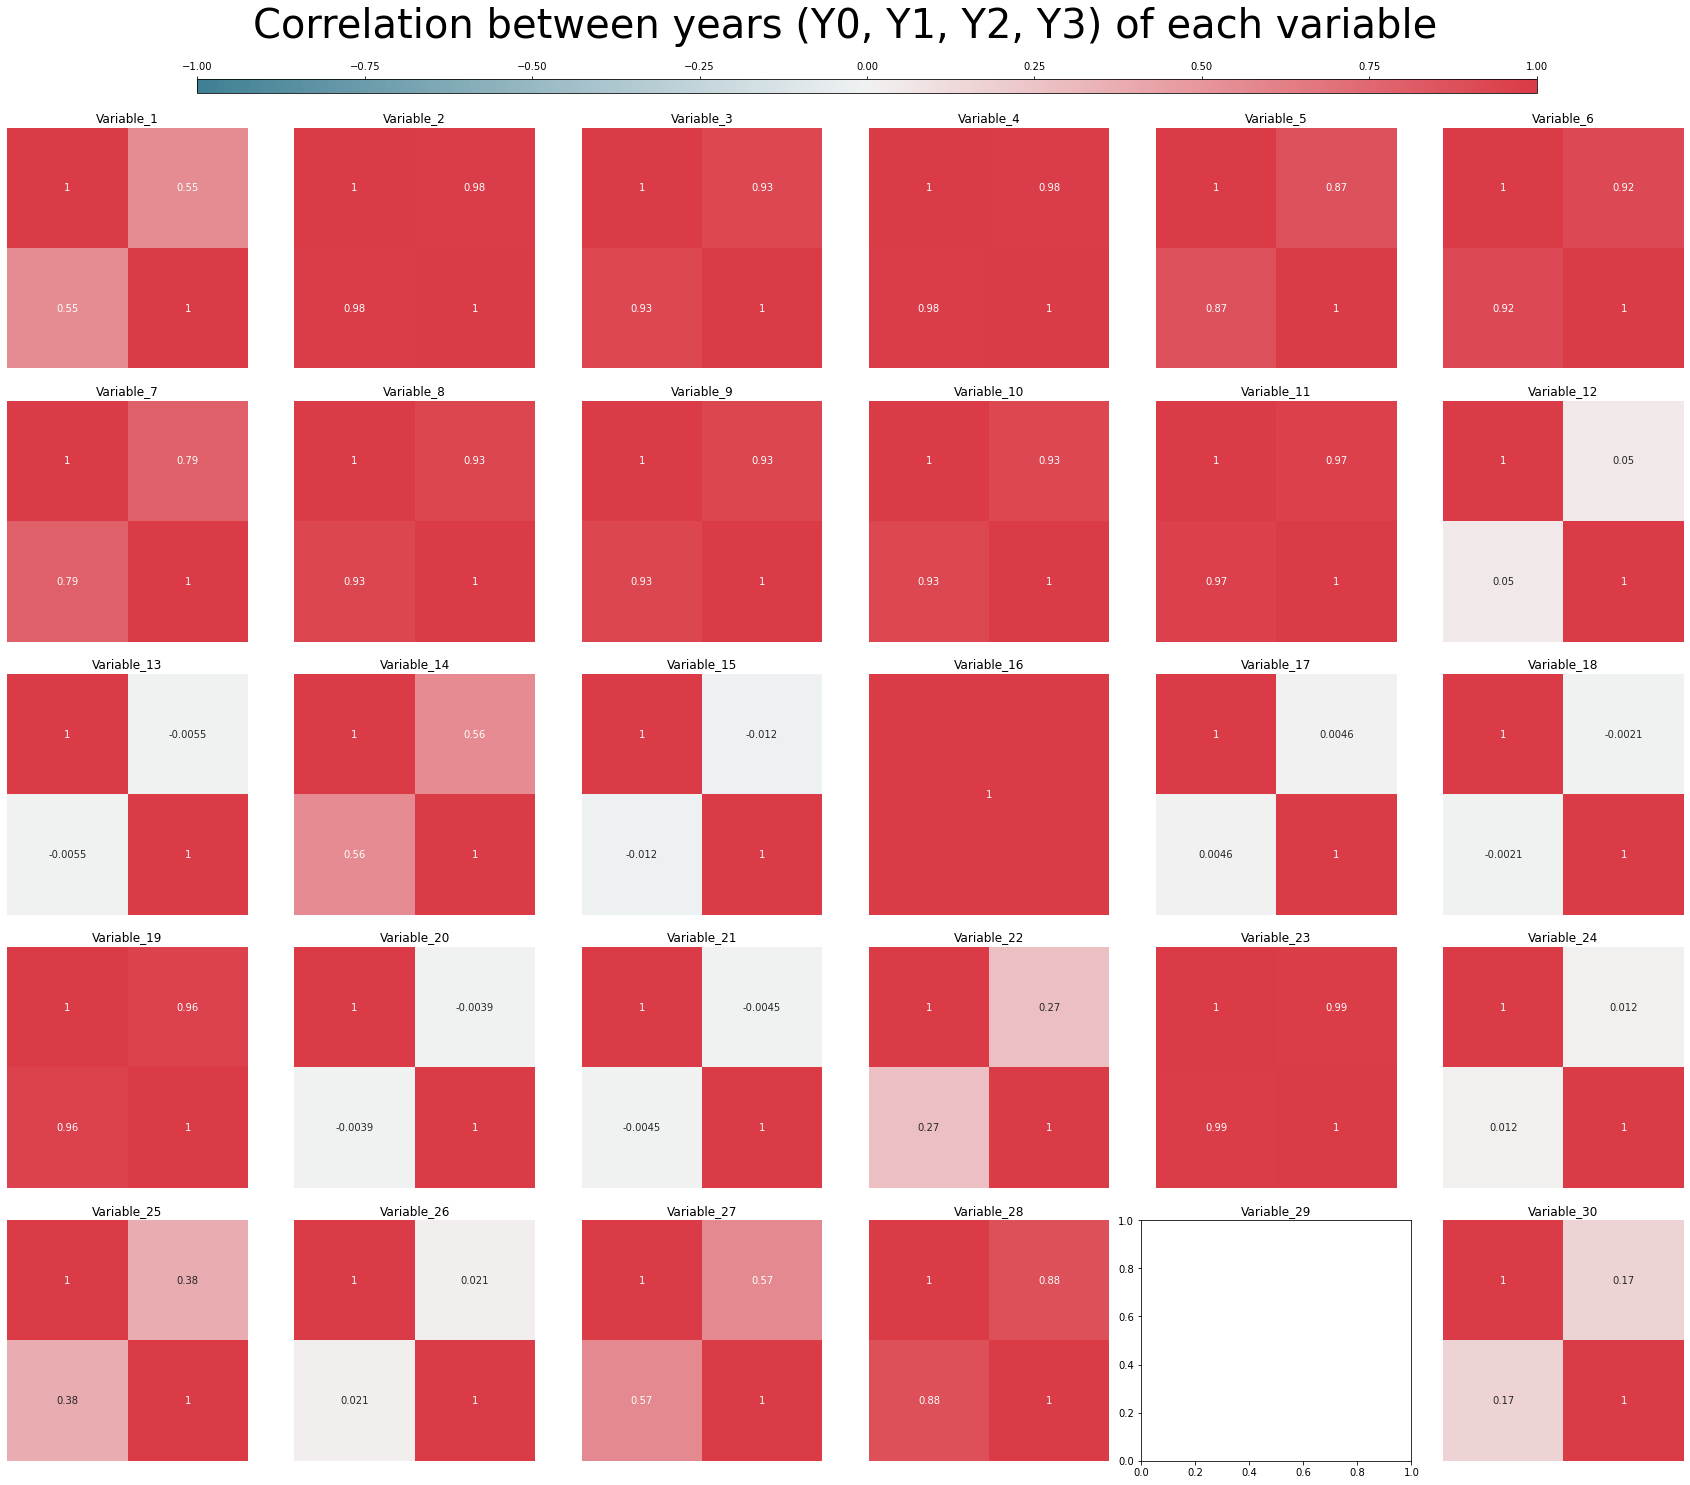

In [28]:
plot_within_var_corr(df_train_1)

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\1651739324.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


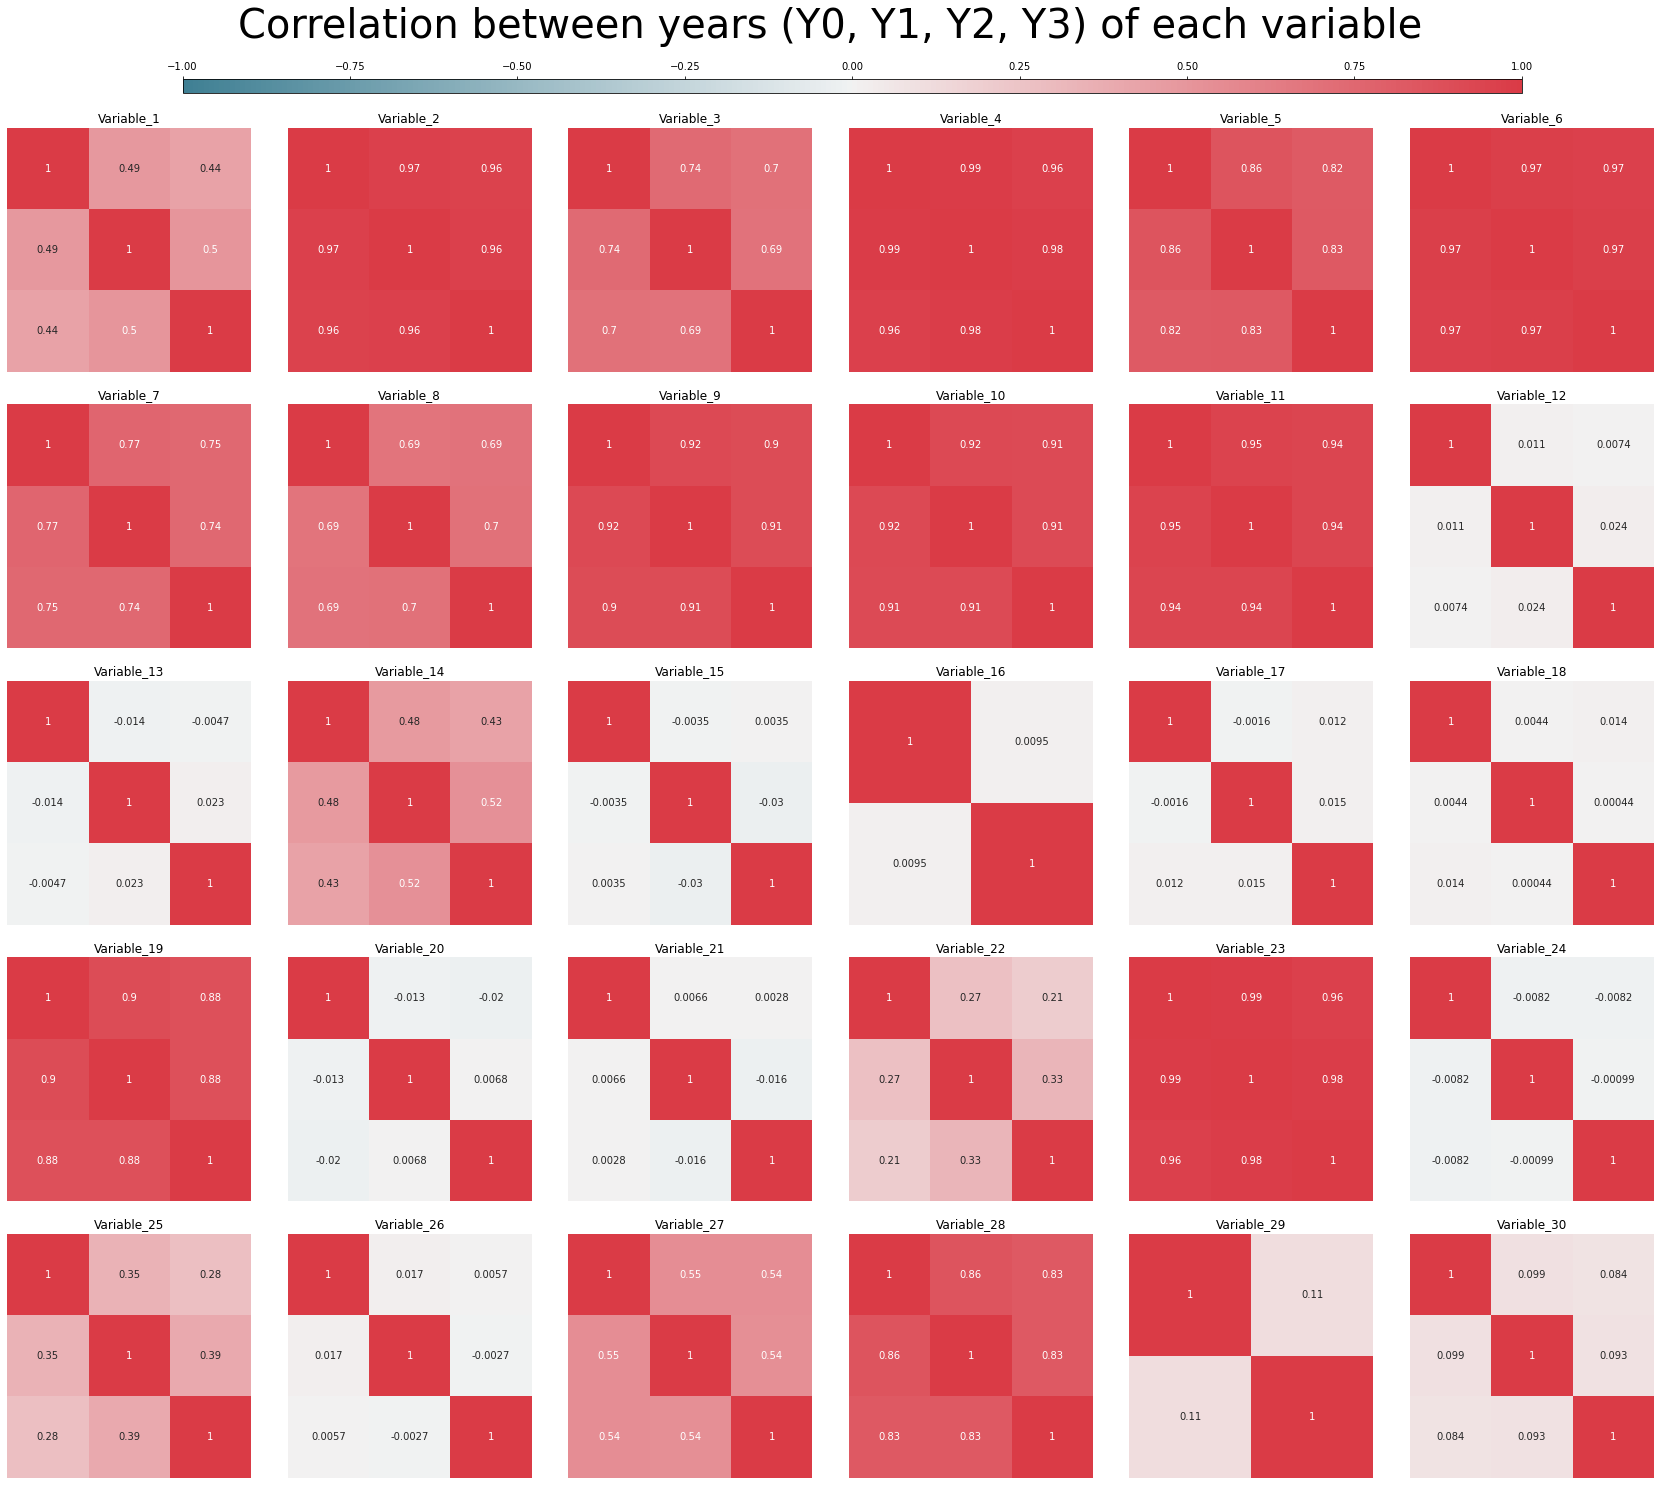

In [29]:
plot_within_var_corr(df_train_2)

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\1651739324.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


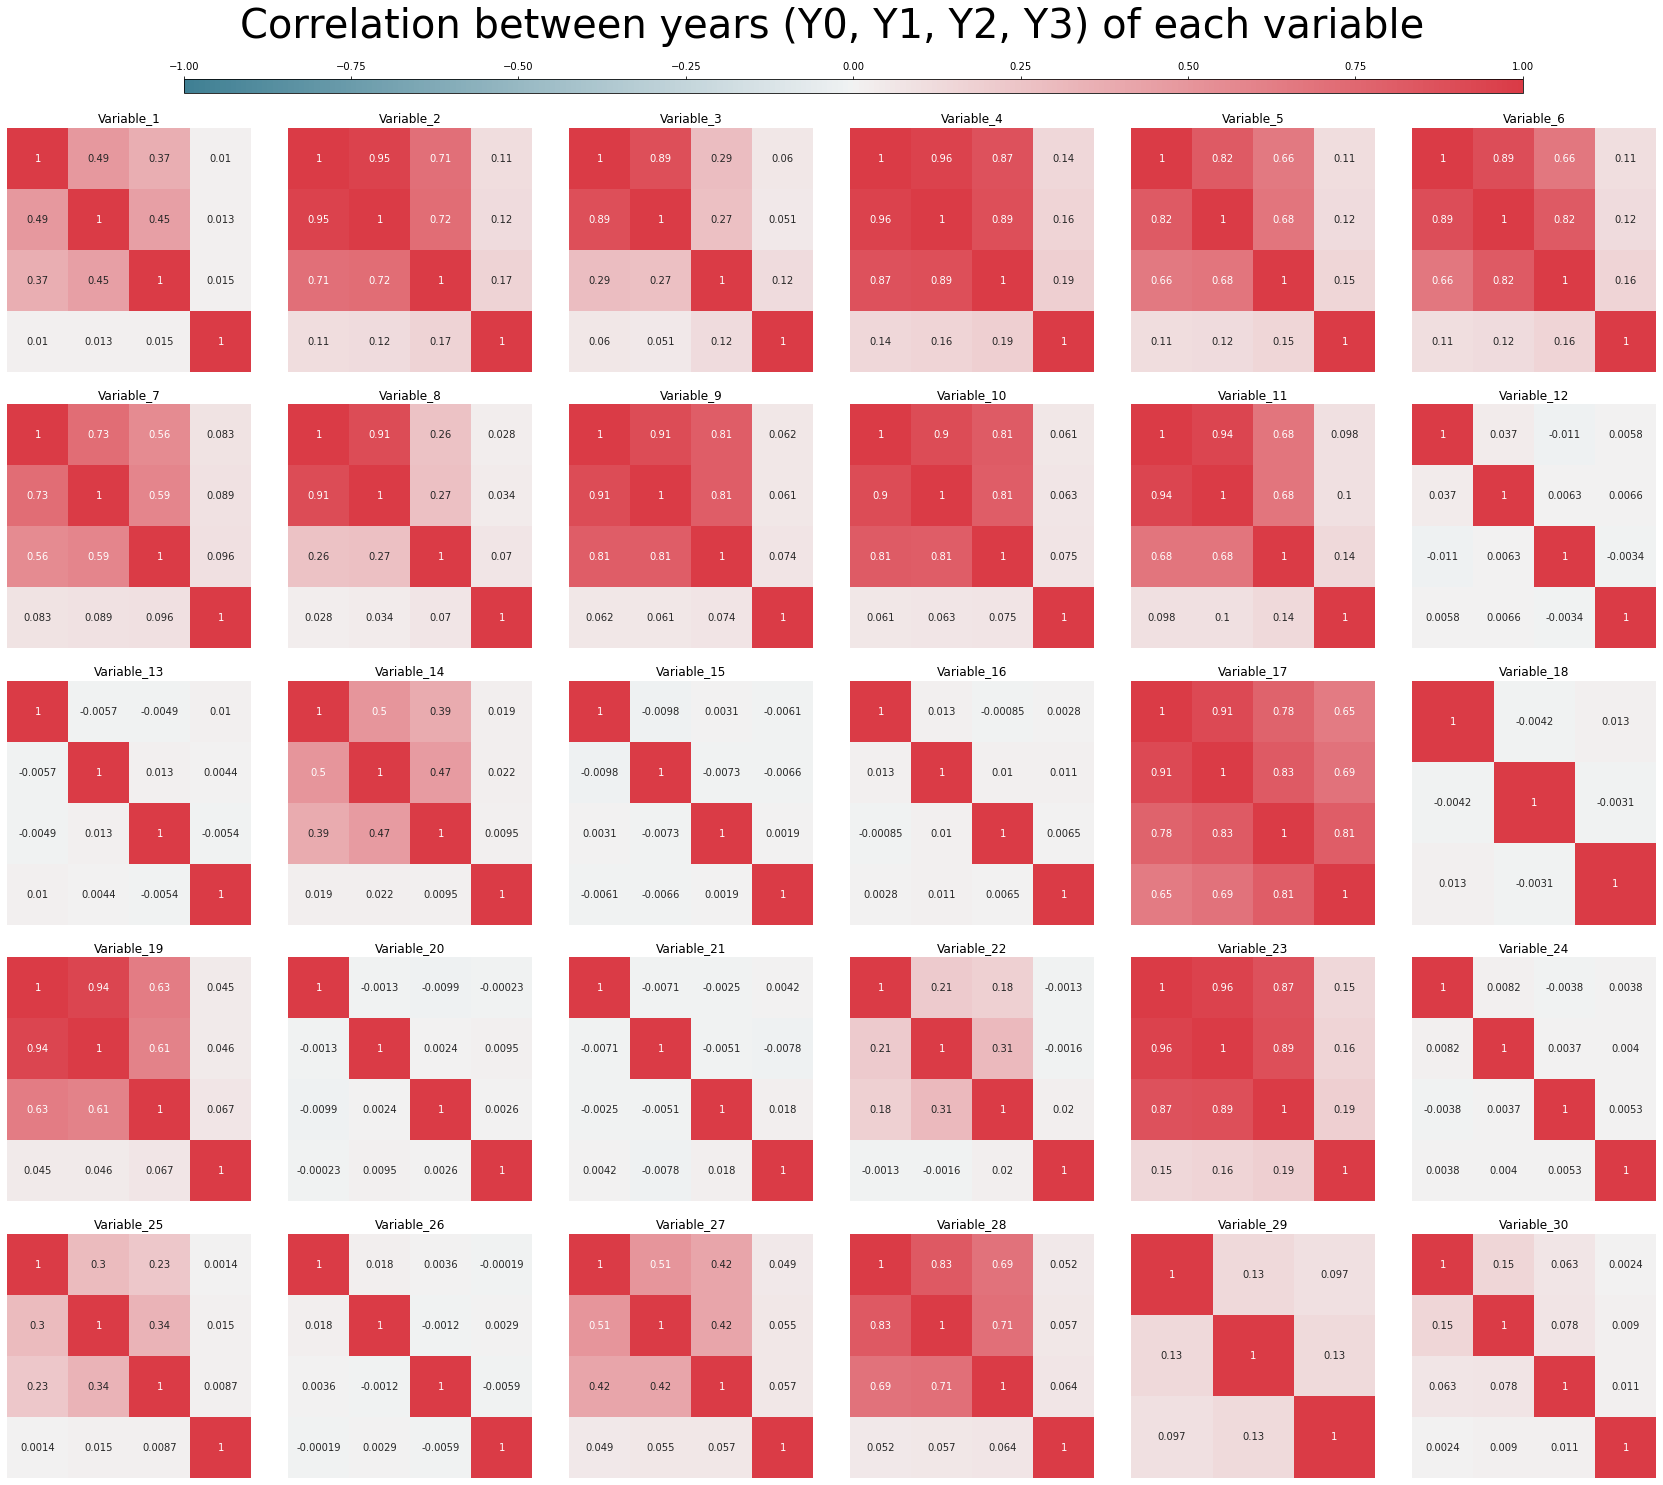

In [30]:
plot_within_var_corr(df_train_3)

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\1651739324.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


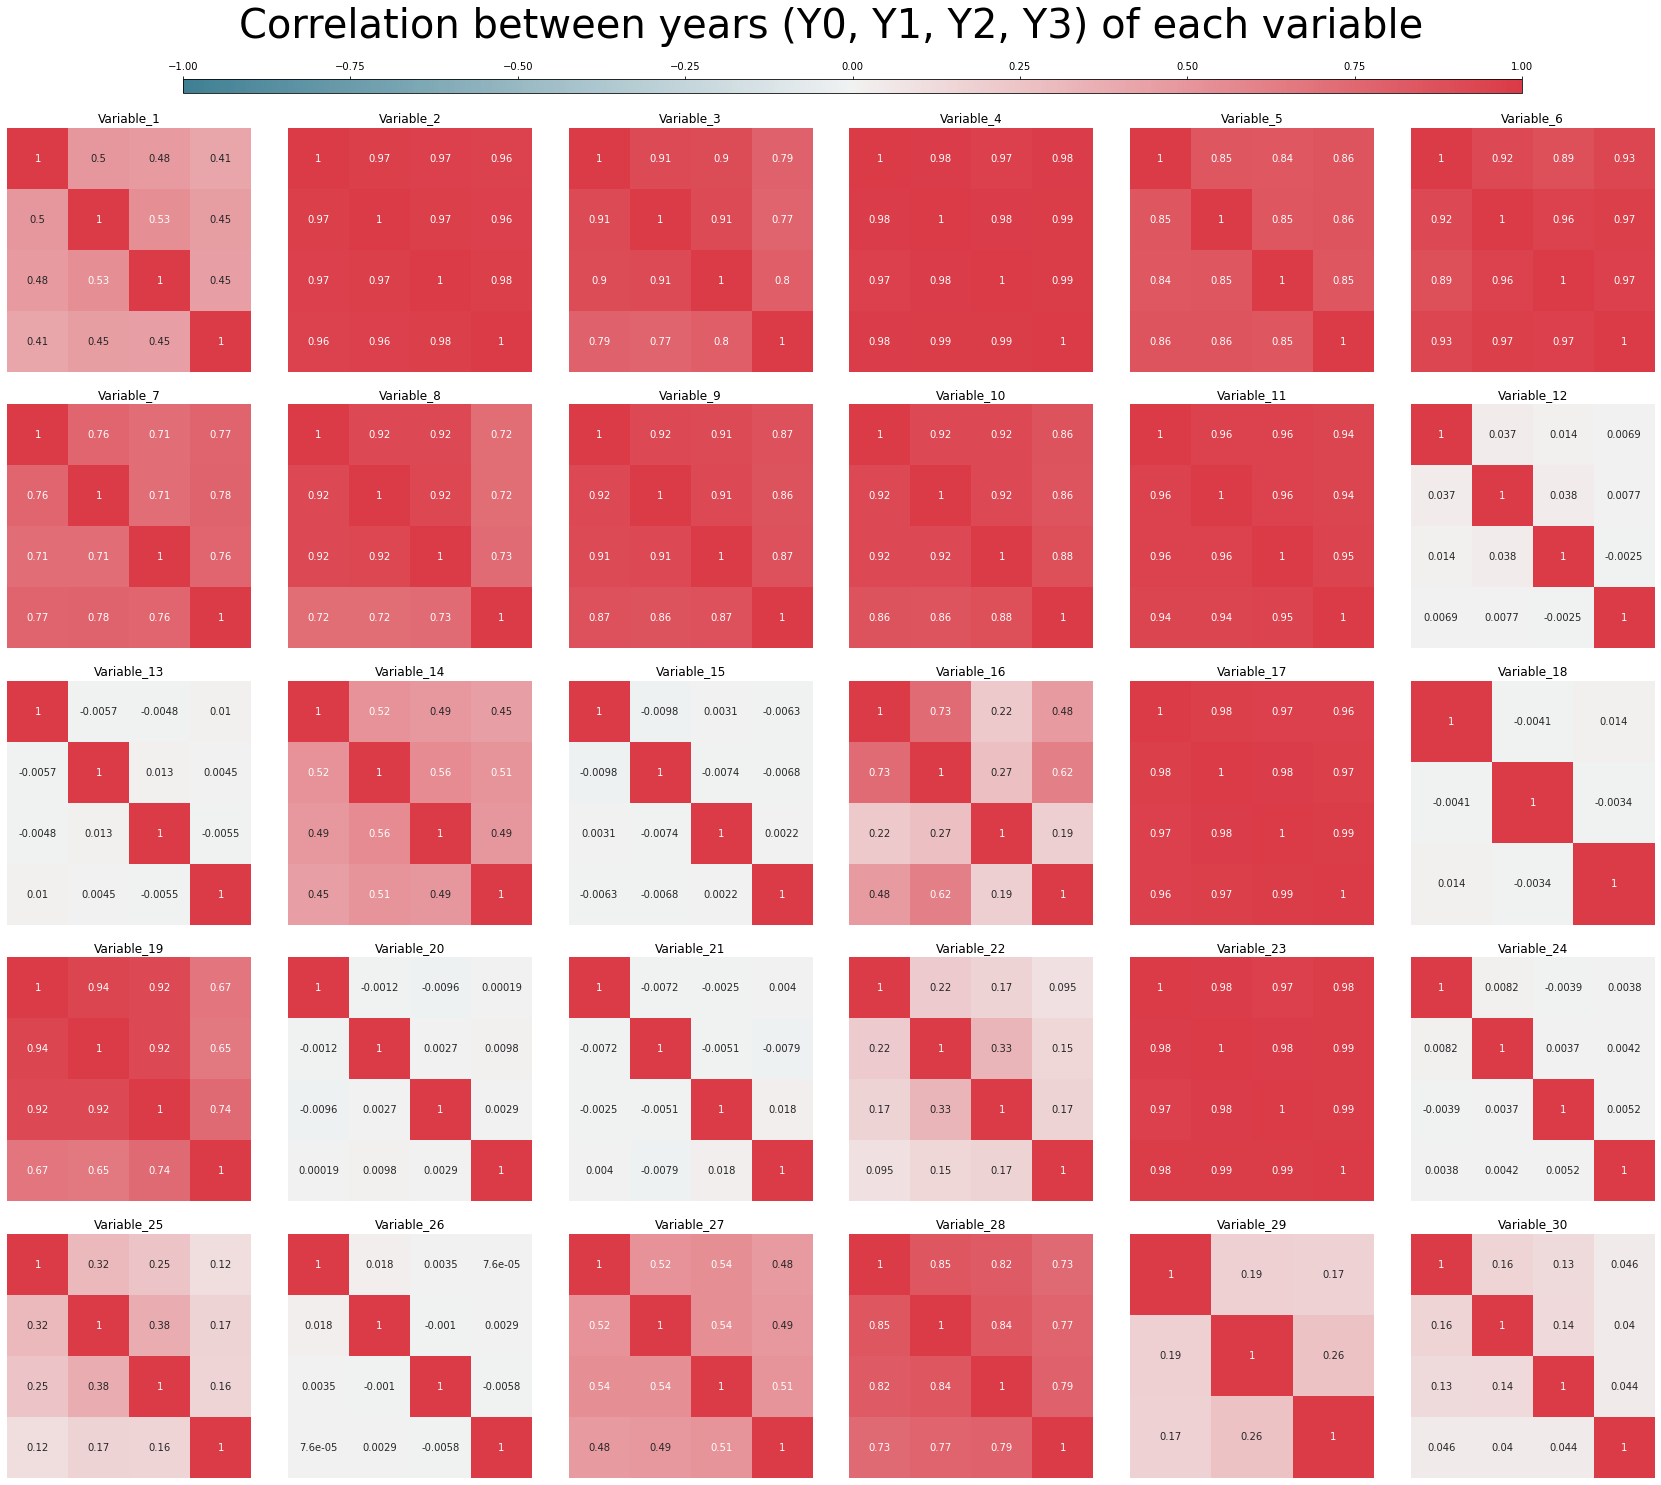

In [31]:
plot_within_var_corr(df_train_4)

#### 2. Correlation between *variables* for each year

In [32]:
# correlation of variables in each year (between all Y0's, Y1's, etc.) AFTER handling missing data
def plot_between_var_corr(df):
    max_year_index = max([int(col[-1]) for col in filter(lambda x: x.startswith("Variable_"), df.columns)])
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, axs = plt.subplots(max_year_index+1, 1, figsize = (20,20*(max_year_index+1)))

    for i in range(max_year_index + 1):
        cols = list(filter(lambda x: x.endswith(f'_Y{i}'), df.columns))
        axs[i].set_title(f"Y{i}")
        sns.heatmap(data=df[cols].corr(), ax=axs[i], cmap=cmap, annot=True, vmin=-1, vmax=1,
                    square=True, cbar=False)

    fig.colorbar(axs[0].get_children()[0], ax=axs.ravel().tolist(), aspect=100, 
                 location="top", orientation="horizontal", anchor=(0.5, 1.57+0.05*(max_year_index+1)))
    fig.suptitle("Correlation between variables in each year", fontsize=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.918+0.01*(max_year_index+1))

    plt.show()

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


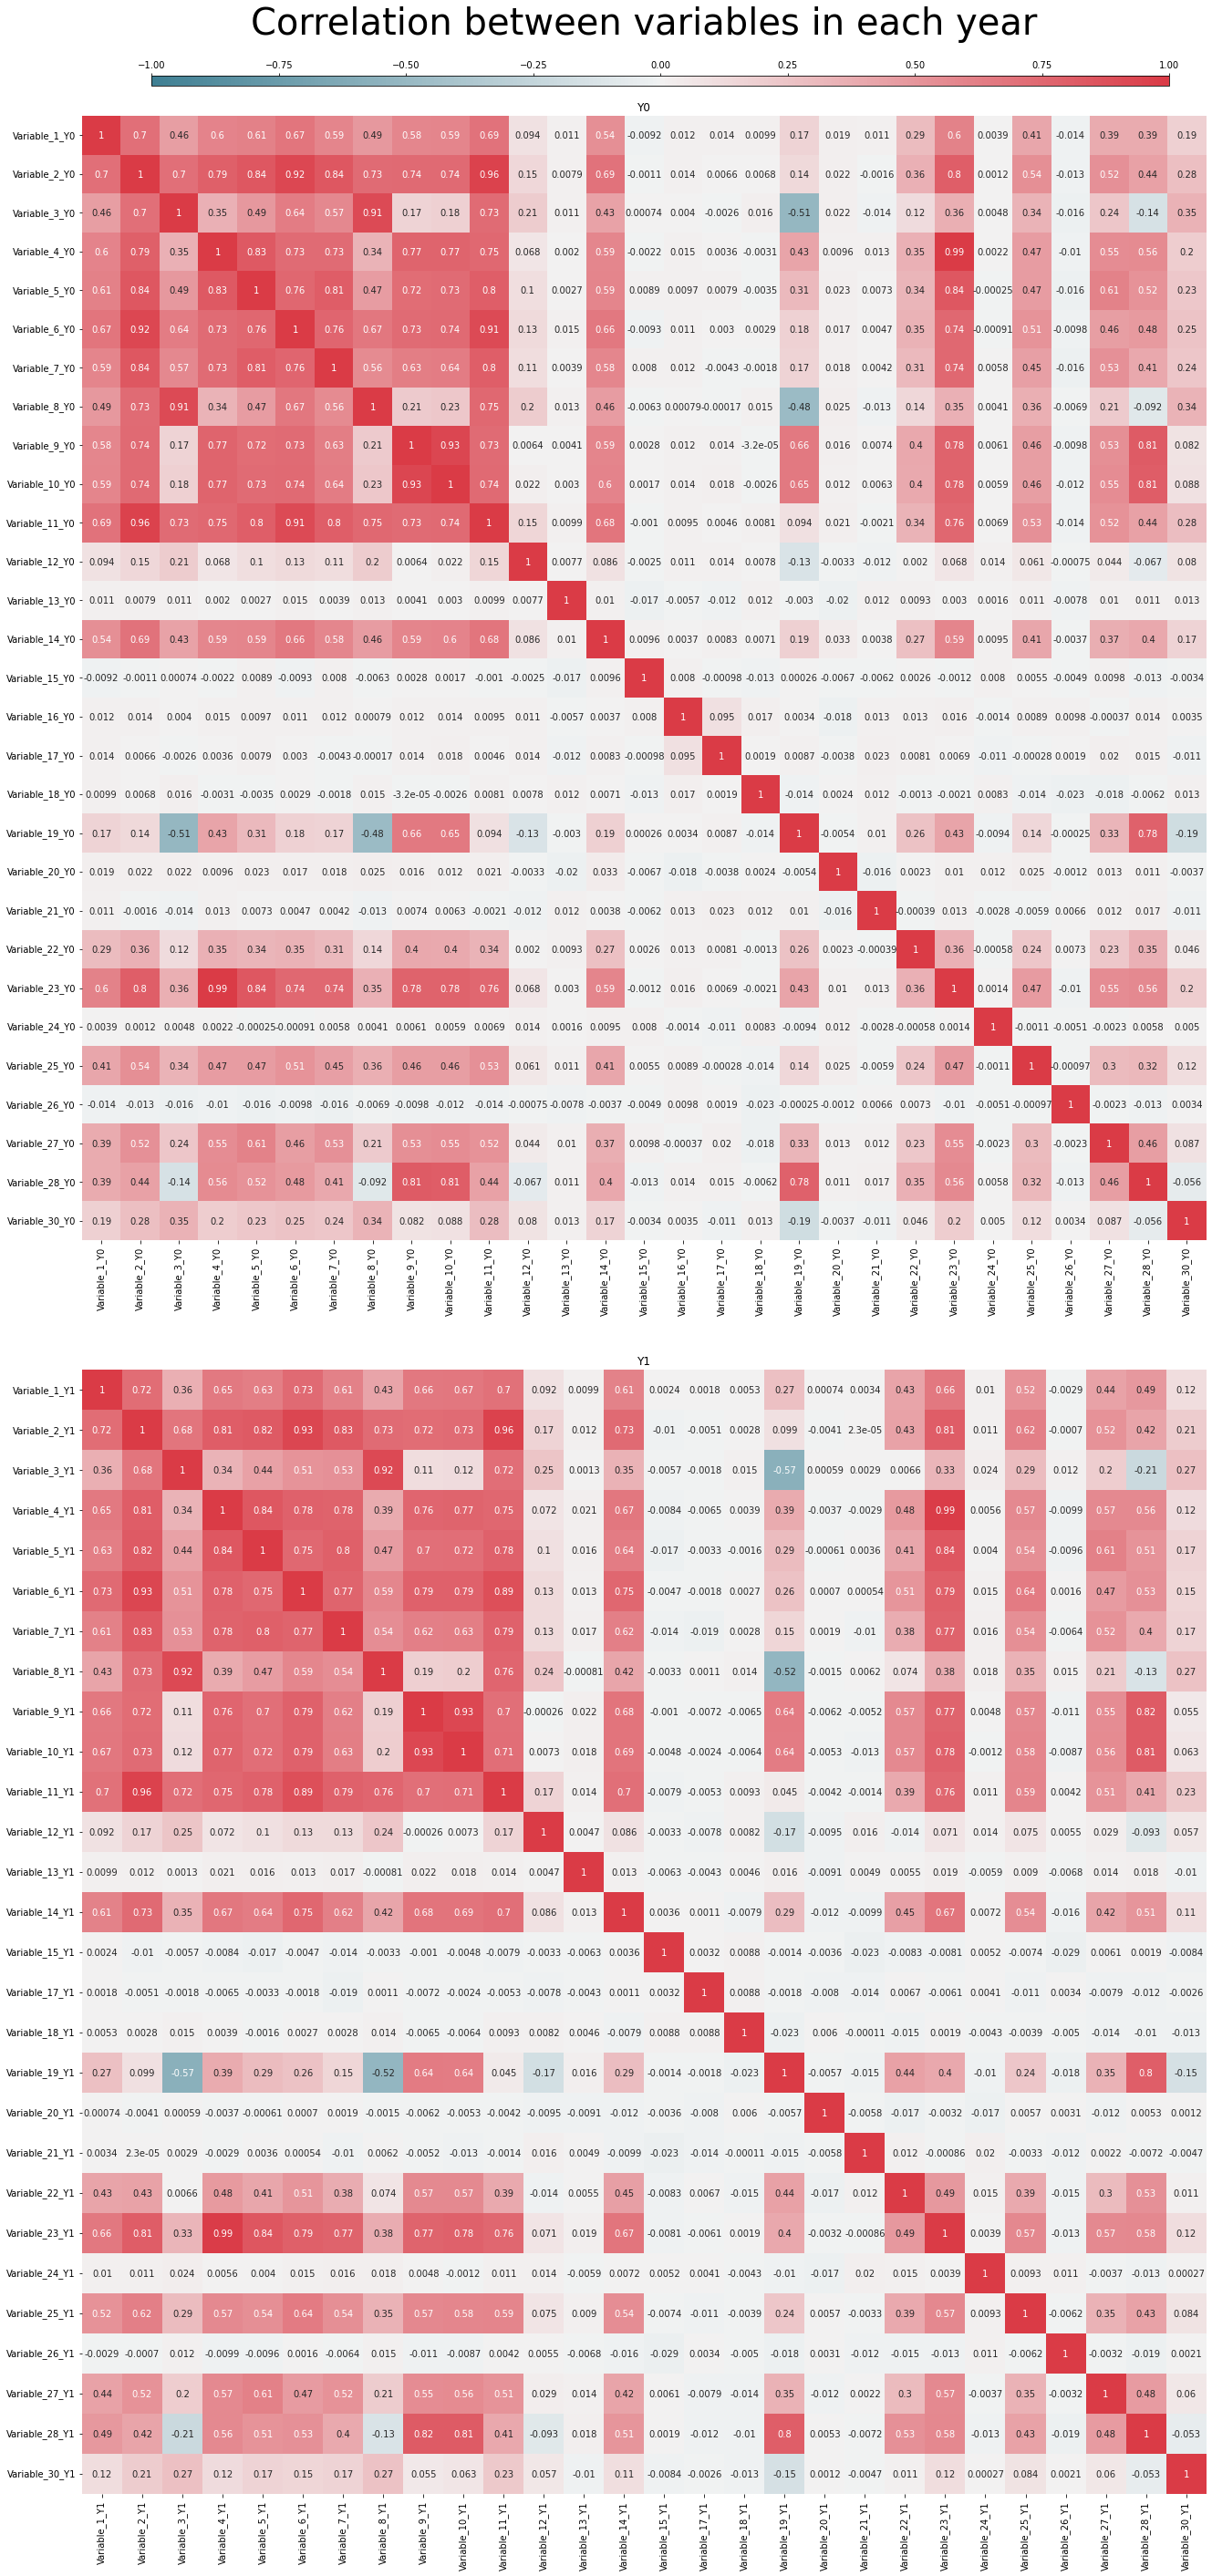

In [33]:
plot_between_var_corr(df_train_1)

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


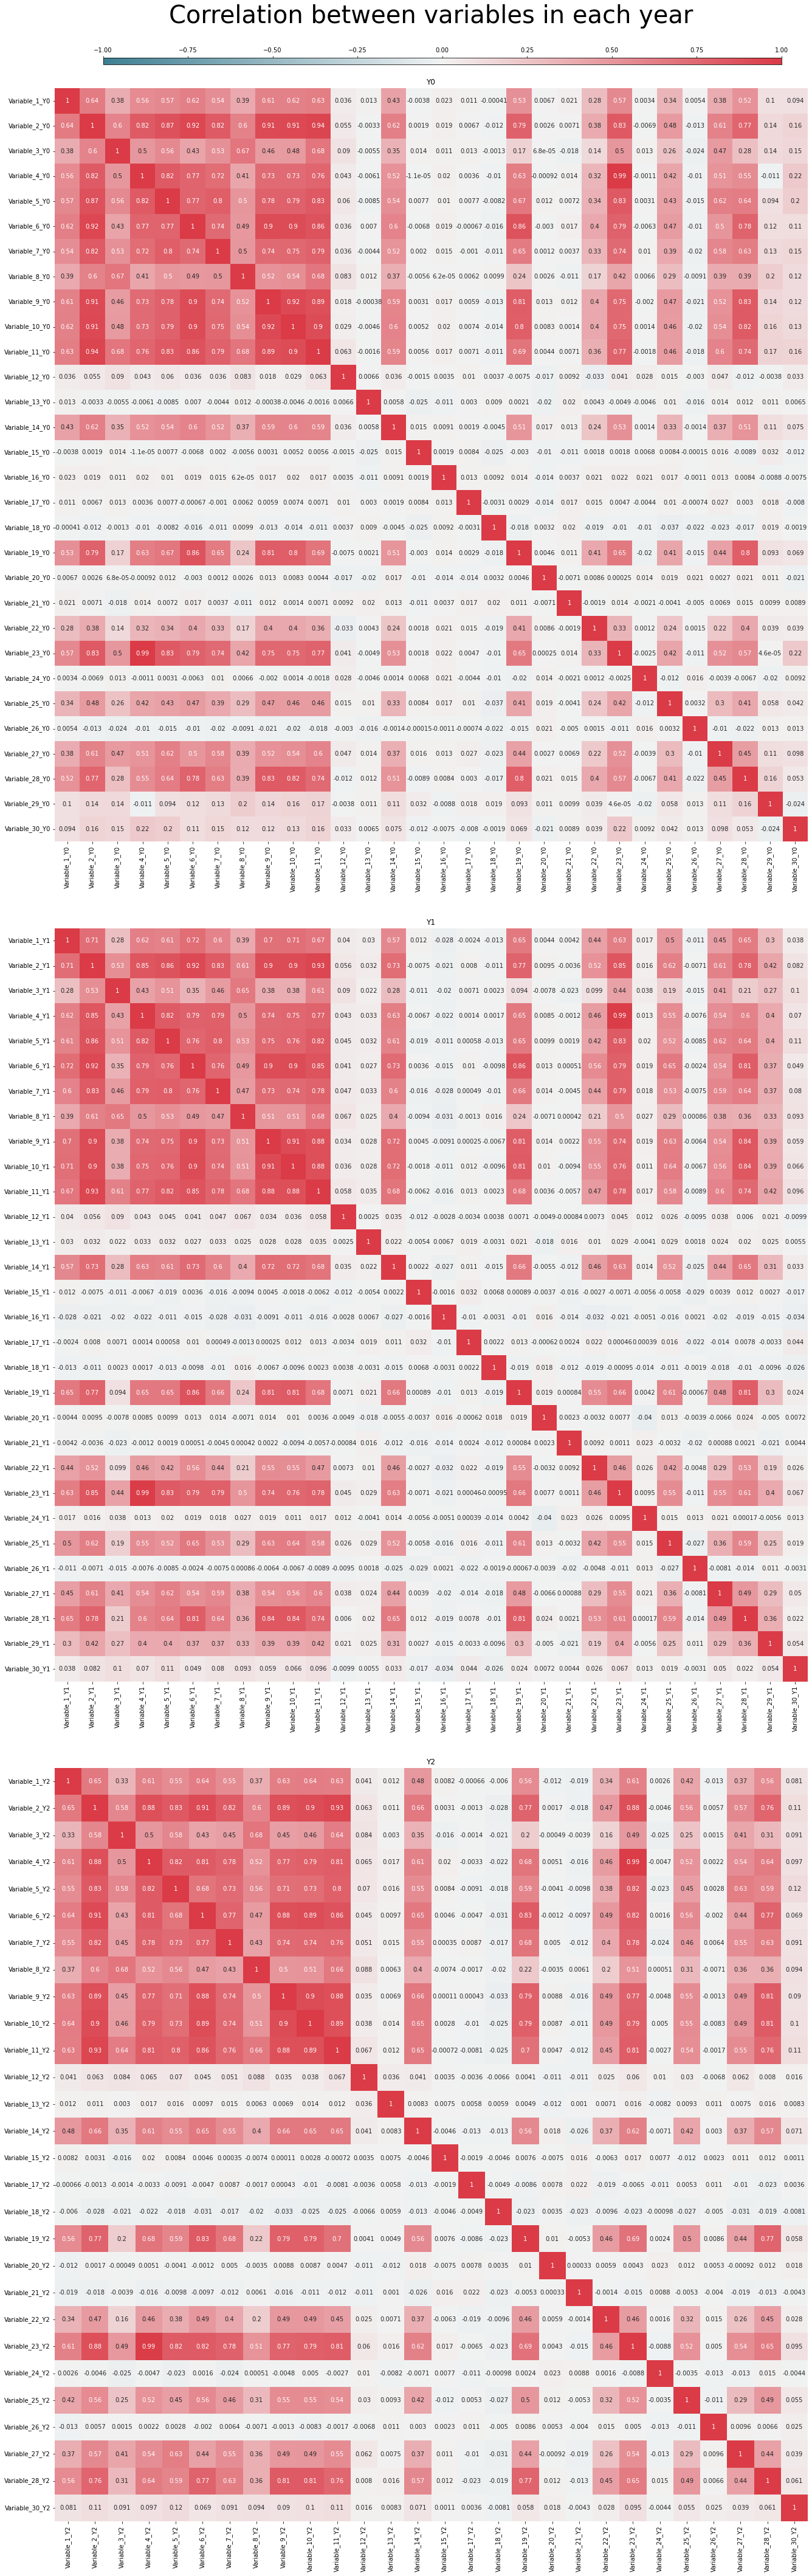

In [34]:
plot_between_var_corr(df_train_2)

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


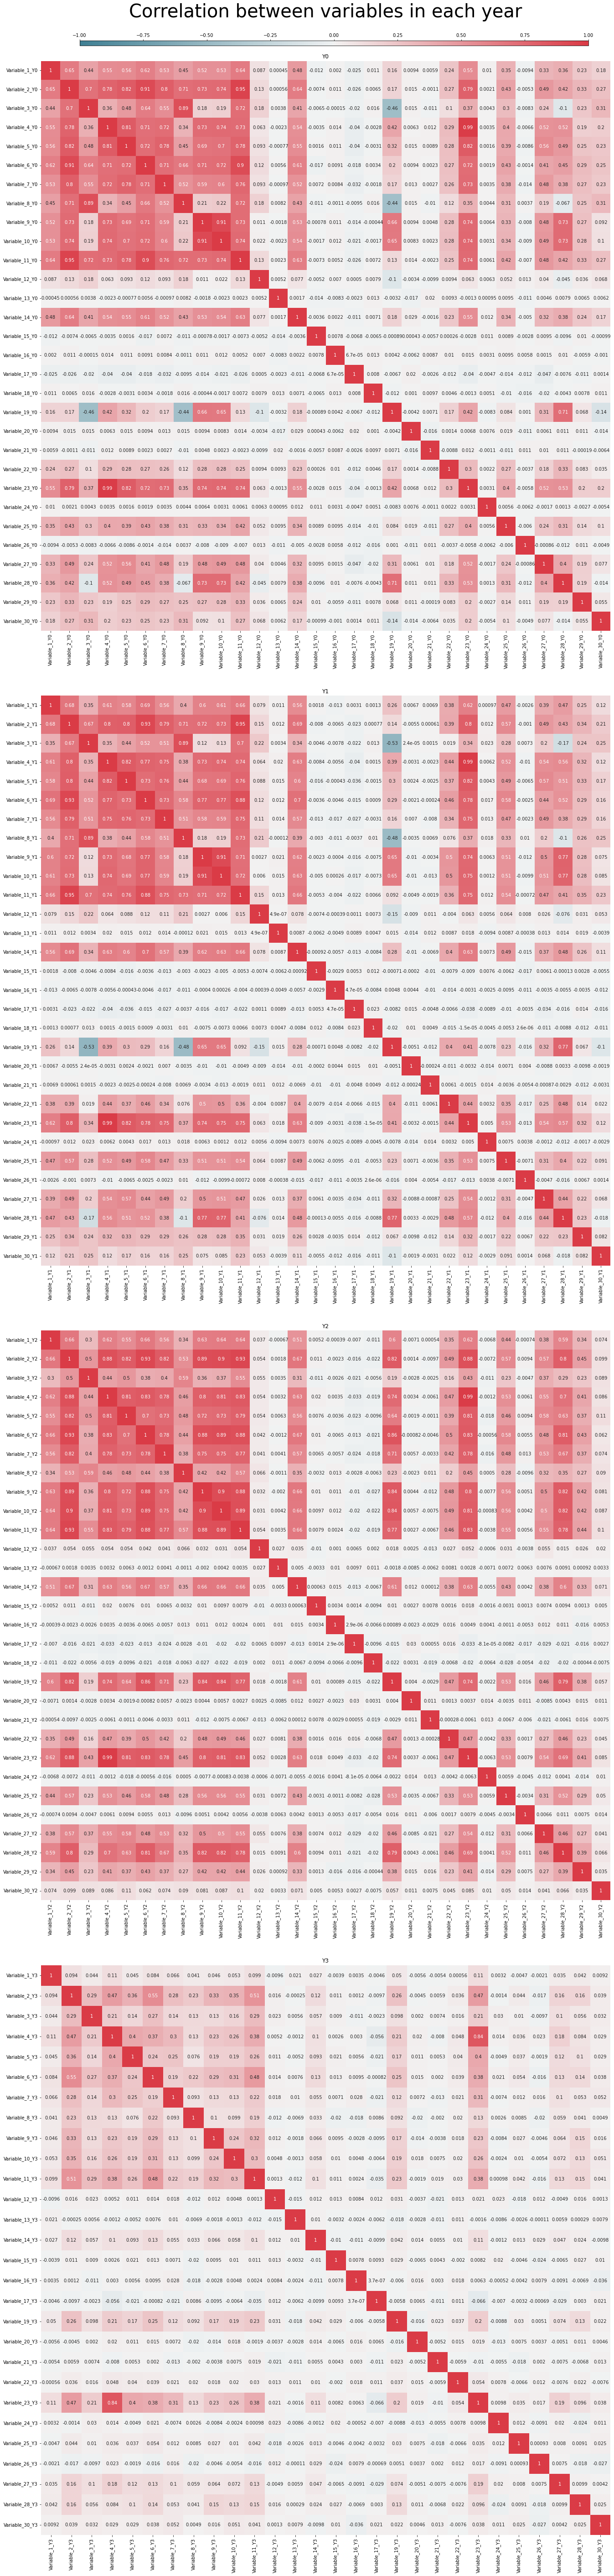

In [35]:
plot_between_var_corr(df_train_3)

C:\Users\peter\AppData\Local\Temp\ipykernel_15704\2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


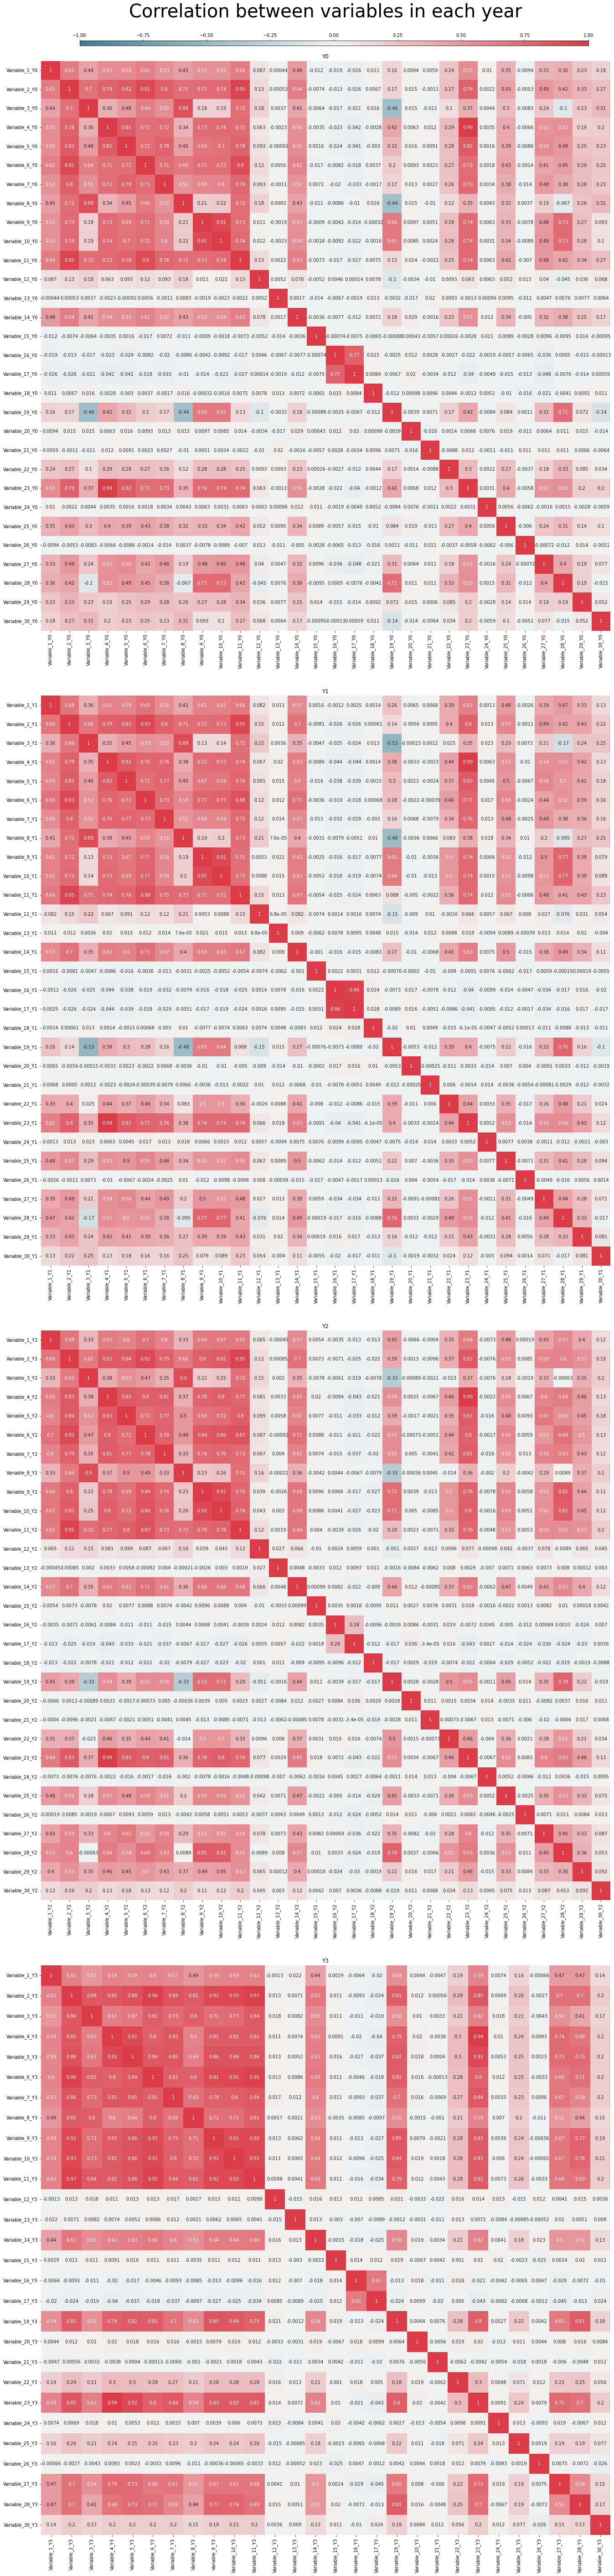

In [36]:
plot_between_var_corr(df_train_4)

#### Remove columns with high correlation to other columns
This includes removing columns of some of the years (Y0 - Y3) for one variable, as well as removing columns for an entire variable.

In [37]:
# columns for variables with high inter-variable (between years) correlation, by observing
# the first set of (4) plots. For these columns, only the Y0 column will be kept due to least 
# amount of missing data in the original dataset.
high_within_corr_cols = list(range(2,12)) + [16, 17, 19, 23, 28]
# columns for variables with high between-variable correlation to other columns, by observing
# the second set of (4) plots.
high_between_corr_cols = [4, 5, 6, 7, 8, 10, 11, 17, 23, 28]

# Since the four datasets (each with a different method of handling missing data) have about 
# the same inter-feature correlation, same treatment will be applied on each datasets, by applying
# the function defined here.
def drop_high_corr_col(df):
    col_to_drop = list(filter(lambda x: x.startswith("Variable") and int(x.split("_")[1]) in high_within_corr_cols and not x.endswith("Y0"), df.columns))
    col_to_drop.extend(list(filter(lambda x: x.startswith("Variable") and int(x.split("_")[1]) in high_between_corr_cols and x not in col_to_drop, df.columns)))  
    return df.drop(columns=col_to_drop)

df_train_1 = drop_high_corr_col(df_train_1)
df_train_2 = drop_high_corr_col(df_train_2)
df_train_3 = drop_high_corr_col(df_train_3)
df_train_4 = drop_high_corr_col(df_train_4)

## Feature selection based on the relationship to the outcome

In [38]:
# using anova correlation and kendall's rank coefficient to filter out low correlated variables
cutoff = 0.05
def check_corr_anova(df, features, target="risk_rating"):
    return np.array(df.columns[6:])[f_classif(df.loc[:,features], df[target])[1] <= cutoff].tolist()

def check_corr_kendall(df, features, target="risk_rating"):
    important_feature_kendall = []
    for col in features:
        tau, p_val = kendalltau(df.loc[:, col].to_numpy().reshape(-1,1), df[target])
        if p_val <= cutoff:
            important_feature_kendall.append(col)
    return important_feature_kendall

# for now, select features that are significant using EITHER tests (by using union on the results of both)
important_features_1 = set(check_corr_kendall(df_train_1, df_train_1.columns[6:])).union(check_corr_anova(df_train_1, df_train_1.columns[6:]))
important_features_2 = set(check_corr_kendall(df_train_2, df_train_2.columns[6:])).union(check_corr_anova(df_train_2, df_train_2.columns[6:]))
important_features_3 = set(check_corr_kendall(df_train_3, df_train_3.columns[6:])).union(check_corr_anova(df_train_3, df_train_3.columns[6:]))
important_features_4 = set(check_corr_kendall(df_train_4, df_train_4.columns[6:])).union(check_corr_anova(df_train_4, df_train_4.columns[6:]))

# save selected features to file
with open("../references/selected_features.txt", "w") as f:
    f.write(",".join(important_features_1))
    f.write("\n")
    f.write(",".join(important_features_2))
    f.write("\n")
    f.write(",".join(important_features_3))
    f.write("\n")
    f.write(",".join(important_features_4))

In [39]:
# remove the insignificant columns in each dataframe
df_train_1 = df_train_1.loc[:, df_train_1.columns[:6].tolist() + list(important_features_1)]
df_train_2 = df_train_2.loc[:, df_train_2.columns[:6].tolist() + list(important_features_2)]
df_train_3 = df_train_3.loc[:, df_train_3.columns[:6].tolist() + list(important_features_3)]
df_train_4 = df_train_4.loc[:, df_train_4.columns[:6].tolist() + list(important_features_4)]

In [40]:
# save to files
df_train_1.to_csv("../data/processed/df_train_1.csv")
df_train_2.to_csv("../data/processed/df_train_2.csv")
df_train_3.to_csv("../data/processed/df_train_3.csv")
df_train_4.to_csv("../data/processed/df_train_4.csv")